# Fuzzy Clustering using QPSO

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## import ExtractRulesQPSO class
import sys, os
sys.path.append(os.getcwd() + '/scripts')
from ExtractRulesQPSO import ExtractRulesQPSO
from FuzzyClustering import FuzzyClustering

## QPSO

In [2]:
q = ExtractRulesQPSO(20, 100, 10)
# q.solver(1,2)
# q.best_particle

## Testing FuzzyClustering class

In [3]:
data = np.array(np.random.rand(100,20))

fc = FuzzyClustering(data)

fc.data

array([[-1.        ,  0.70000896,  0.38225665, ..., -0.04447092,
        -0.61109589,  0.55864898],
       [-0.2116727 ,  0.06586584,  0.27034329, ...,  0.63238589,
        -0.28987359,  0.79777262],
       [ 0.84069612, -0.53538267, -0.76439124, ..., -0.99004748,
        -0.94313139,  0.58813202],
       ...,
       [-0.09785471,  0.57571447, -0.34094902, ..., -0.70972136,
         0.90801051, -0.80787768],
       [-0.55960519,  0.25141261, -0.82418955, ...,  0.94399542,
        -0.11765012, -0.09874512],
       [ 0.8356671 ,  0.12322756,  0.29156296, ...,  0.43282603,
        -0.28840166,  0.88972099]])

## Example 

### Generating synthetic data

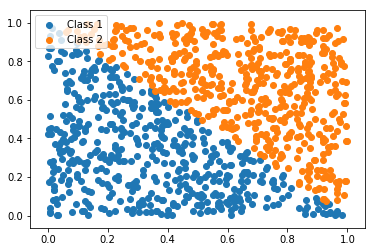

In [4]:
random_numbers = np.random.rand(1000)
N = 1000
tmp_c1 = []
tmp_c2 = []

for i in range(N):
    v_tmp = np.random.rand(2)
    
    if (v_tmp[0] + v_tmp[1] <= 1):
        tmp_c1.append(v_tmp)
    else:
        tmp_c2.append(v_tmp)

## Synthetic data for two classes
data_c1 = np.array(tmp_c1)
data_c2 = np.array(tmp_c2)

plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')
plt.legend()

### Applying fuzzy clustering

In [5]:
fc1 = FuzzyClustering(data_c1)
fc2 = FuzzyClustering(data_c2)

In [13]:
## finding centers
fc1.extractClusteringCenters()
centers_c1 = fc1.getDenormalizedClusterCenters()
fc2.extractClusteringCenters()
centers_c2 = fc2.getDenormalizedClusterCenters()

In [11]:
centers_c1, centers_c2

(array([[0.36213197, 0.29011666],
        [0.15908139, 0.61959709],
        [0.68887473, 0.10584109],
        [0.00888091, 0.01623507]]), array([[0.70580977, 0.68539559],
        [0.34160147, 0.86165155],
        [0.83807448, 0.34161157]]))

### Plotting resulting cluster centers

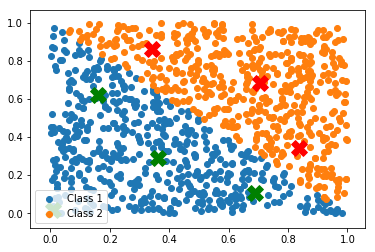

In [26]:
plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')

## Add centers of class 1
for cs in centers_c1:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'green', s = 250)

## Add centers of class 2
for cs in centers_c2:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'red', s = 250)

plt.legend()

### Use QPSO to optimize the rules